In [1]:
!pip install nltk

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [2]:
df = pd.read_csv('data.csv')


In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
StopWords = set(stopwords.words('english'))


In [5]:
df['Tweet'] = df['Tweet'].apply(lambda x: x.lower())#lowercase

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'(@[\w]+\s)+','username ',x))#username

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+|www\S+','http',x))#link

# df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'#(([\w]+\s[\w]+)+)',r'\1',x))#hashtags 

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'(#[\w]+)+',' ',x))#removing all hashtags

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('[^\w\s]','',x))#punctuation and all emojis

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('amp','and',x))

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('\s+',' ',x))#remove whitespaces

df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))#lemmatization

df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in StopWords]))


In [6]:
df['category'] = df['Label'].apply(lambda x: 1 if x =='Joyous' else 2 if x =='Sarcasm' else 0)

In [7]:
df.head()

,Label,Tweet,category
0,Schadenfreude,username police officer question think wa america,0
1,Schadenfreude,username please report get username said idk s...,0
2,Sarcasm,username right wing christianity mean ignorant...,2
3,Schadenfreude,username part history wont whats point getting...,0
4,Sarcasm,username guess forecast wa wrong least previou...,2


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [9]:
X, y = df['Tweet'], df['Label']
metrics = []

skf = KFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = TfidfVectorizer(ngram_range=(1,3), max_features=1500)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    svm = LinearSVC()
    svm.fit(X_train_dtm, y_train)
    y_pred_class = svm.predict(X_test_dtm)

    metrics.append(accuracy_score(y_test, y_pred_class))

metrics = np.array(metrics)
print('Mean accuracy: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
print(classification_report(y_test, y_pred_class))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Mean accuracy:  0.6106263679129269
Std for accuracy:  0.00815710617137719
               precision    recall  f1-score   support

       Joyous       0.60      0.75      0.66       280
      Sarcasm       0.51      0.31      0.38       216
Schadenfreude       0.67      0.70      0.69       305

     accuracy                           0.61       801
    macro avg       0.59      0.59      0.58       801
 weighted avg       0.60      0.61      0.60       801



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

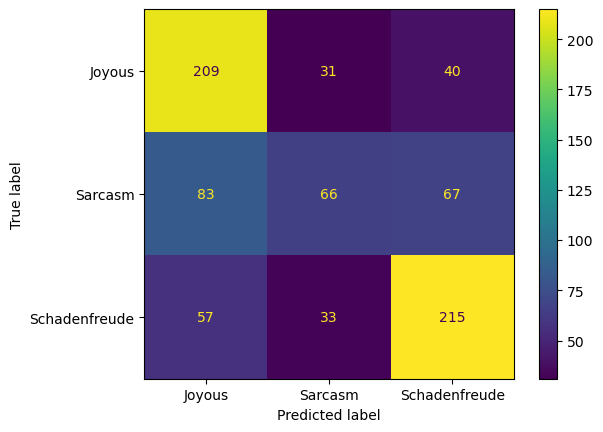

In [11]:
cm = confusion_matrix(y_test, y_pred_class, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

In [12]:
coefficients = svm.coef_

# Get the classes
classes = svm.classes_

# Print the coefficients for each class
top_coefficients_per_class = []
for class_idx, class_coef in enumerate(coefficients):
    top_indices = np.argsort(np.abs(class_coef))[::-1][:20]  # Top 20 coefficients
    top_coefficients_per_class.append(top_indices)
print(top_coefficients_per_class)

[array([ 618,  909, 1177, 1208,  316, 1301,   56,  542, 1374, 1334, 1083,
        740,  762,  129, 1153, 1283,  802,  226, 1337,  430]), array([ 542,  319,   29, 1058,  747,  316, 1193,  660,  457, 1162,   24,
        610,  626, 1328, 1374,  769,  832, 1477,  267,  272]), array([ 618,  676,   64,   56,  598,  660, 1208,  329,   97,  204, 1250,
        209,  610,  554, 1107, 1247, 1047, 1479, 1306,  650])]


In [14]:
print(top_coefficients_per_class)


[array([ 618,  909, 1177, 1208,  316, 1301,   56,  542, 1374, 1334, 1083,
        740,  762,  129, 1153, 1283,  802,  226, 1337,  430]), array([ 542,  319,   29, 1058,  747,  316, 1193,  660,  457, 1162,   24,
        610,  626, 1328, 1374,  769,  832, 1477,  267,  272]), array([ 618,  676,   64,   56,  598,  660, 1208,  329,   97,  204, 1250,
        209,  610,  554, 1107, 1247, 1047, 1479, 1306,  650])]


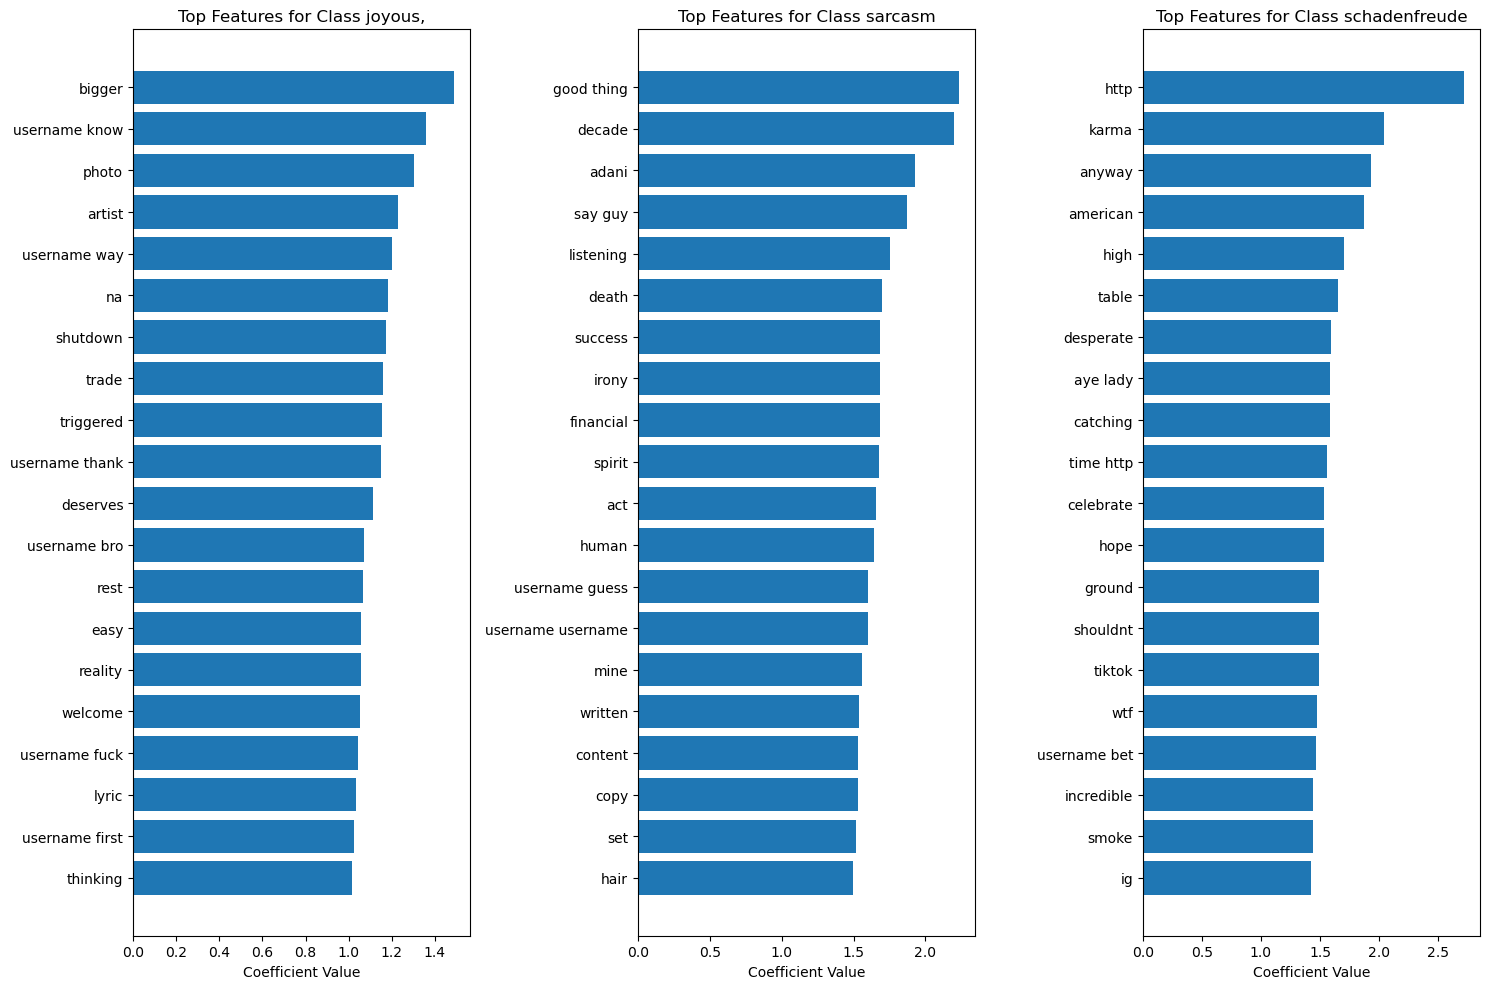

In [15]:
target_names = ['joyous,', 'sarcasm', 'schadenfreude']

# Number of top features to display
top_features_count = 20

# Create a subplot for each class to display the top features
plt.figure(figsize=(15, 10))
for class_idx in range(len(target_names)):
    # Sort coefficients for the current class and get the top 20
    top_feature_indices = np.argsort(coefficients[class_idx])[-top_features_count:]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    
    # Create a subplot for the current class
    plt.subplot(1, 3, class_idx + 1)
    plt.barh(range(top_features_count), coefficients[class_idx][top_feature_indices], align='center')
    plt.yticks(np.arange(top_features_count), top_feature_names)
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for Class {target_names[class_idx]}')

plt.tight_layout()
plt.show()




